In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import cifar10
from keras import models, regularizers, optimizers, losses
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, Input, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from keras import backend as K
from sklearn import metrics

In [12]:
LABELS= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Define the confusion matrix for the results
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)  # Don't rotate (vertically) the y-axis labels
    #hm.invert_yaxis() # Invert the labels of the y-axis
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [13]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

img_rows, img_cols = train_x.shape[1], train_x.shape[2]
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

train_x /= 255
test_x /= 255

num_class = np.size(np.unique(train_y))

train_y = to_categorical(train_y, num_class)
test_y = to_categorical(test_y, num_class)

In [14]:
print(train_x.shape)
print(train_y.shape)
print(num_class)

(50000, 32, 32, 3)
(50000, 10)
10


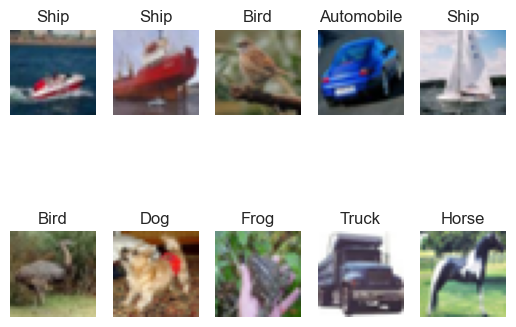

In [15]:
indices = np.random.choice(np.arange(train_x.shape[0]), 10, replace=False)
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure()
for idx, i in enumerate(indices):
    plt.subplot(2, 5, idx+1)
    plt.imshow(train_x[i])
    plt.title(classes[np.argmax(train_y[i])])
    plt.axis('off')
plt.show()

In [16]:
train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    train_x, train_y,
    batch_size=128
    )

validation_generator = test_datagen.flow(
    test_x, test_y,
    batch_size=128
    )

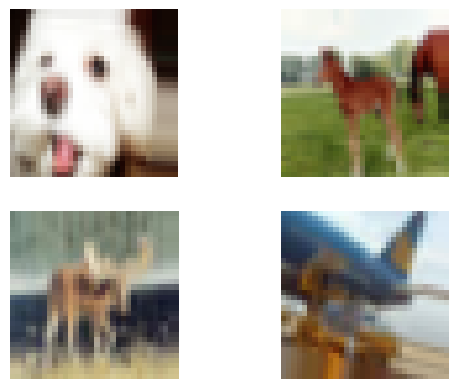

In [17]:
plt.figure()
i = 0
for batch in train_datagen.flow(train_x, batch_size=1):
    plt.subplot(2, 2, i+1)
    plt.imshow(batch.reshape(32, 32, 3))
    plt.axis('off')
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [18]:
model = models.Sequential()
model.add(Input(input_shape))
model.add(Conv2D(16, (3,3), activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.30))
model.add(Flatten())
model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.30))
model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,266 (336.98 KB)

 Trainable params: 86,138 (336.48 KB)

 Non-trainable params: 128 (512.00 B)

In [19]:
epochs = 20
batch_size = 128
opt = optimizers.Adam(0.001)
loss = losses.categorical_crossentropy

model.compile(loss=loss,
              optimizer=opt,
              metrics=['acc'])

In [20]:
history = model.fit(train_generator,
          # batch_size=batch_size,
          epochs=epochs,
          validation_data = validation_generator,
          verbose=1)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - acc: 0.3128 - loss: 2.0999 - val_acc: 0.3360 - val_loss: 2.0214
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - acc: 0.4193 - loss: 1.7262 - val_acc: 0.4769 - val_loss: 1.6088
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - acc: 0.4701 - loss: 1.5799 - val_acc: 0.5036 - val_loss: 1.5873
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - acc: 0.5065 - loss: 1.4780 - val_acc: 0.5188 - val_loss: 1.5361
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - acc: 0.5286 - loss: 1.4135 - val_acc: 0.5301 - val_loss: 1.4967
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - acc: 0.5435 - loss: 1.3653 - val_acc: 0.5843 - val_loss: 1.3000
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - acc: 0.5586 - loss: 1.3279 - val_acc: 0.5975 - val_loss: 1.2378
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - acc: 0.5694 - loss: 1.2945 - val_acc: 0.6215 - val_loss: 1.1691
Epoch 9/20
391/391 ━━━━━━━━━━━━━

In [21]:
score = model.evaluate(test_x, test_y, verbose=0)
pred_y = model.predict(test_x)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Validation loss: 1.013106346130371
Validation accuracy: 0.6723999977111816


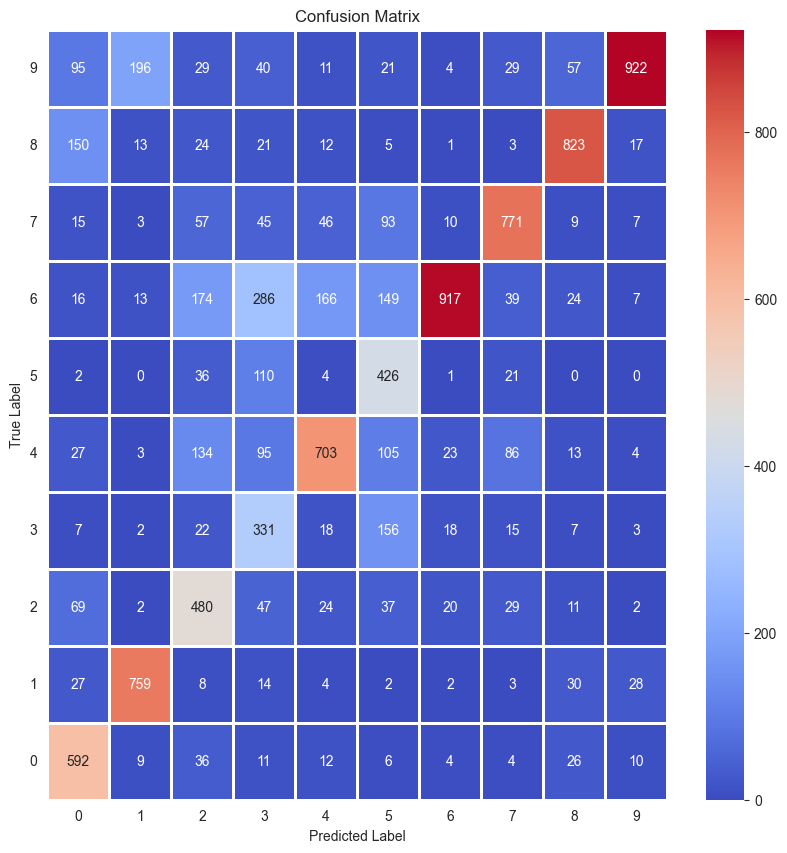

In [22]:
max_pred_y = np.argmax(pred_y, axis=1)
max_test_y = np.argmax(test_y, axis=1)
show_confusion_matrix(max_pred_y, max_test_y, num_class)

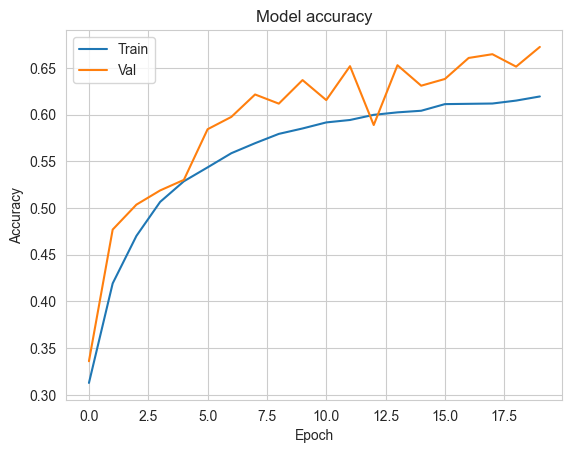

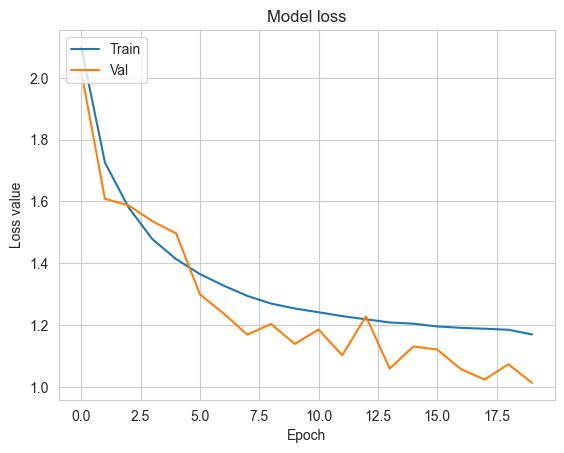

In [23]:
acc = history.history['acc']
loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()